# Определение перспективного тарифа для телеком компании

---
### **Задача:** 
Определить на небольшой выборке клиентов компании "Мегалайн" какой из двух предлагаемых тарифов "Смарт" или "Ультра" принесёт компании больше денег.

### **Дано:** 
Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Эти данные отображены в четырёх таблицах, названия и описания данных которых приведены ниже. 

---


### Описание данных:

Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со - 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Описание тарифов

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей


Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

#### Примечание

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
from IPython.core.display import display, HTML

### Шаг 1. Открываем файл с данными и изучаем  общую информацию. 


In [15]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
internet = pd.read_csv('/datasets/internet.csv')

In [16]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [17]:
display(internet.head())
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [18]:
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [19]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [20]:
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод

В таблице `users` 
- в столбце **reg_date** нужна замена типа данных object на datetime
- в столбце **churn_date** пропуски, но они не случайны и не требуют замены, а вот для остальных данных просится замена типа на datetime

В таблице `internet` 
- присутствует лишний столбец, дублирующий индексы
- в столбце **session_date** нужна замена типа данных object на datetime
- в столбце **mb_used** следует откруглить значения в большую сторону в связи с тарифной политикой "Мегалайна"

В таблице `calls` 
- в столбце **call_date** нужна замена типа данных object на datetime
- в столбце **duration** пропуски скорее всего значат, что разговор был менее минуты, но в тарифном плане компании такие звонки приравниваются к минуте разговора, поэтому необходимо заменить нули на единицы, а так же округлить все нецелые числа вверх в связи с тарифной политикой компании.

В таблице `messages` 
- в столбце **message_date** нужна замена типа данных object на datetime



### Шаг 2. Подготавливаем данные к анализу. 




В таблице `calls` 

- в столбце **duration** пропуски скорее всего значат, что разговор был менее минуты, но в тарифном плане компании такие звонки приравниваются к минуте разговора, поэтому необходимо заменить нули на единицы, а так же округлить все нецелые числа вверх в связи с тарифной политикой компании. 
- возможно часть нулей в минутах звонка, это недозвоны, тогда это лишние данные, которые я бы удалил, но в данном случае у меня нет идей как определеить какие именно из звонков не состоялись. 

In [21]:
display(HTML('<style>.container {width: 90% !important;}</style>'))

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users[users['churn_date'].isna()==False]['churn_date'],format='%Y-%m-%d')

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].where(calls['duration']!=0, 1)
calls['duration'] = np.ceil(calls['duration']).astype('int')
print('Проверка округления всех минут в большую сторону, проверка замены нулевых минут')
display(calls)

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

del internet['Unnamed: 0']

Проверка округления всех минут в большую сторону, проверка замены нулевых минут


,id,call_date,duration,user_id
0,1000_0,2018-07-25,1,1000
1,1000_1,2018-08-17,1,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [22]:
#создаём датафрейм словарь по месяцам
month_names = pd.DataFrame({'month_id': ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12'], 'month': ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь',  'октябрь', 'ноябрь', 'декабрь']})
month_names['month_id'] = pd.to_numeric(month_names['month_id'])
month_names['month_id'].astype('int')
#добавим в таблицу сумму минут и количество звонков для каждого пользователя в зависимости от месяца
calls['month_id'] = pd.DatetimeIndex(calls['call_date']).month
calls = calls.merge(month_names, on = 'month_id', how = 'left') 
calls_pivot = calls.groupby(['user_id','month']).agg({'duration':['sum','count'] }).reset_index()
calls_pivot.set_axis(['user_id','month','sum_of_min','count_of_calls'],axis = 'columns',inplace = True)

#посчитаем количество отправленных сообщений по месяцам для каждого пользователя
messages['month_id'] = pd.DatetimeIndex(messages['message_date']).month
messages = messages.merge(month_names, on = 'month_id', how = 'left')
messages_pivot = messages.groupby(['user_id','month']).agg({'message_date': 'count'}).reset_index()
messages_pivot.columns = ['user_id','month','sum_messages']

#посчитаем объём израсходанного интернет - тррафика по месяцам для каждого пользователя
internet['month_id'] = pd.DatetimeIndex(internet['session_date']).month
internet = internet.merge(month_names, on = 'month_id', how = 'left')
internet_pivot= internet.groupby(['user_id','month']).agg({'mb_used': 'sum'}).reset_index()
internet_pivot.columns = ['user_id','month','sum_internet']

In [23]:
#найдем помесячную выручку с каждого пользователя исходя их его тарифа
users_final = calls_pivot.merge(messages_pivot, how = 'outer', on = ['user_id','month']).merge(internet_pivot, how = 'outer', on = ['user_id','month'])


users_tariff = users.loc[:, ['user_id', 'tariff']]#делаем срез данных по пользователю и его тарифу
users_final = users_final.merge(users_tariff, on = 'user_id')#добавляем в таблицу используемые пользователем названия тарифов
users_final['tariff_name'] = users_final['tariff'] 
users_final = users_final.merge(tariffs, on = 'tariff_name', how = 'left')#добавляем данные о соответсвующих тарифах
del users_final['tariff']#удаляем лишний столбец

def profit(data):
    """
    функция считает общую выручку с каждого пользователя, учитывая параметры тарифа
    """
    profit = 0
    if (data['sum_of_min'] - data['minutes_included'] > 0):
        profit += data['rub_per_minute']*(data['sum_of_min'] - data['minutes_included'])
    if (data['sum_messages'] - data['messages_included'] > 0):
        profit += data['rub_per_message']*(data['sum_messages'] - data['messages_included'])
    if (data['sum_internet'] - data['mb_per_month_included'] > 0):
        profit += math.ceil((data['sum_internet'] - data['mb_per_month_included'])/1024)*data['rub_per_gb']
    profit += data['rub_monthly_fee'] 
    return profit
users_final['profit'] = users_final.apply(profit,axis = 1)#добавляем в таблицу столбец общей выручки
print('Таблица, подготовленная для анализа')
display(users_final)
print()
print('Выводим данные о звонках клиента 1489, у которого мы наблюдаем пропуски в итоговой таблице, чтобы проверить совершал ли он звонки')
print(calls[calls['user_id']=='1489'])

Таблица, подготовленная для анализа


,user_id,month,sum_of_min,count_of_calls,sum_messages,sum_internet,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,август,418.0,52.0,81.0,14070.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,декабрь,341.0,46.0,70.0,9827.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,июль,346.0,47.0,75.0,14016.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,июнь,187.0,43.0,60.0,23257.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,май,164.0,22.0,22.0,2256.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,август,NaN,NaN,17.0,11066.0,smart,50,15360,500,550,200,3,3,550.0
3210,1489,декабрь,NaN,NaN,35.0,17341.0,smart,50,15360,500,550,200,3,3,950.0
3211,1489,ноябрь,NaN,NaN,20.0,17516.0,smart,50,15360,500,550,200,3,3,1150.0
3212,1489,октябрь,NaN,NaN,21.0,19588.0,smart,50,15360,500,550,200,3,3,1550.0



Выводим данные о звонках клиента 1489, у которого мы наблюдаем пропуски в итоговой таблице, чтобы проверить совершал ли он звонки
Empty DataFrame
Columns: [id, call_date, duration, user_id, month_id, month]
Index: []


Визуально можно заметить пропуски в столбцах `sum_of_min`, `count_of_calls` ,например, для клиента `user_id = 1489`, действительно, если обратиться к таблице звонков по номеру данного id, датафрейм будет пуст, что говорит о том, что данный клиент использовал тариф только для смс и интернета, а итоговая таблица составлена верно

### Вывод

Сформировали отдельно таблицы:
- нашли сумму минут и количество звонков для каждого пользователя по месяцам
- нашли количество сообщений отправленное каждым пользователем по месяцам
- нашли количество потраченных мегабайт каждым пользователем по месяцам


Объединили эти таблицы в одну, добавив параметры по тарифам, посчитали общую выручку с каждого пользователя

Таким образом, получили таблицу для дальнейшего анализа


 ### Шаг 3. Анализируем данные. 

In [9]:
#найдем дисперсию для суммы минут, количества смс, потраченных мегабайт в зависимости от тарифа  
min_var_ultra = np.var(users_final[users_final['tariff_name']=='ultra']['sum_of_min'], ddof=1)
min_var_smart = np.var(users_final[users_final['tariff_name']=='smart']['sum_of_min'], ddof=1)
mes_var_ultra = np.var(users_final[users_final['tariff_name']=='ultra']['sum_messages'], ddof=1)
mes_var_smart = np.var(users_final[users_final['tariff_name']=='smart']['sum_messages'], ddof=1)
mb_var_ultra = np.var(users_final[users_final['tariff_name']=='ultra']['sum_internet'], ddof=1)
mb_var_smart = np.var(users_final[users_final['tariff_name']=='smart']['sum_internet'], ddof=1)

#объединим дисперсию в одну таблицу 
variance = pd.DataFrame({'sum_of_min' : [min_var_ultra,min_var_smart], 'sum_messages' : [mes_var_ultra,mes_var_smart], 'sum_internet' :[mb_var_ultra,mb_var_smart]})
variance.index = ['ultra','smart']
print('Таблица дисперсии')
display(variance)
print()

#найдем стандартное отклонение для суммы минут, количества смс, потраченных мегабайт в зависимости от тарифа  
deviation = pd.DataFrame({'sum_of_min' : [np.sqrt(min_var_ultra),np.sqrt(min_var_smart)], 'sum_messages' : [np.sqrt(mes_var_ultra),np.sqrt(mes_var_smart)], 'sum_internet' :[np.sqrt(mb_var_ultra),np.sqrt(mb_var_smart)]})
deviation.index = ['ultra','smart']
print('Таблица стандартного отклонения')
display(deviation)
print()

#найдем среднее значение для суммы минут, количества смс, потраченных мегабайт в зависимости от тарифа 
mean = users_final.groupby('tariff_name').agg({'sum_of_min' : 'mean','sum_messages' : 'mean','sum_internet' : 'mean', 'profit' : 'mean'})
print('Таблица средних значений')
display(mean)
print()

Таблица дисперсии


,sum_of_min,sum_messages,sum_internet
ultra,99062.633405,2109.659183,9.904344e+07
smart,37577.967083,717.594201,3.444310e+07



Таблица стандартного отклонения


,sum_of_min,sum_messages,sum_internet
ultra,314.742170,45.931026,9952.057054
smart,193.850373,26.787949,5868.824472



Таблица средних значений


,sum_of_min,sum_messages,sum_internet,profit
tariff_name,,,,
smart,430.609987,38.716441,16236.472621,1311.615074
ultra,560.113565,61.161006,19686.767179,2071.065990


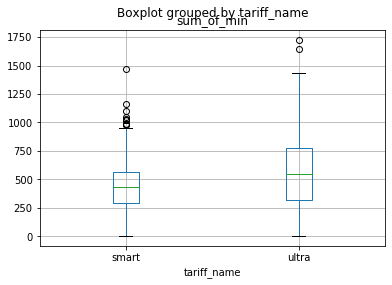

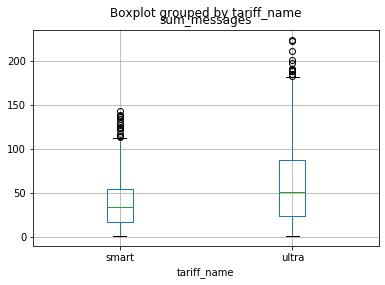

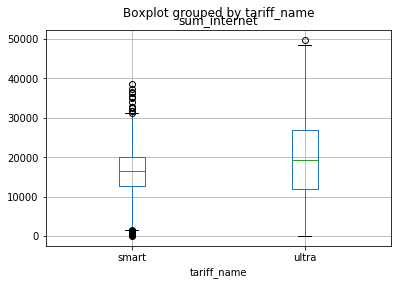

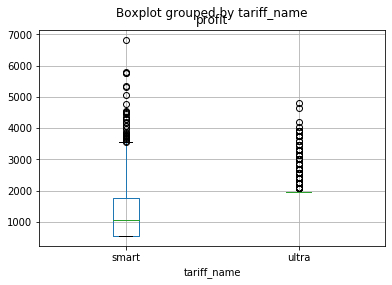

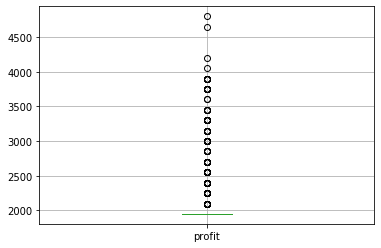

In [10]:
#пострим диаграммы размаха для сравнения выборок по тарифам
users_final.boxplot('sum_of_min', by = 'tariff_name')
plt.show()
users_final.boxplot('sum_messages', by = 'tariff_name')
plt.show()
users_final.boxplot('sum_internet', by = 'tariff_name')
plt.show()
users_final.boxplot('profit', by = 'tariff_name')
plt.show()
(users_final.query('tariff_name =="ultra"')
            .boxplot('profit'))
plt.show()

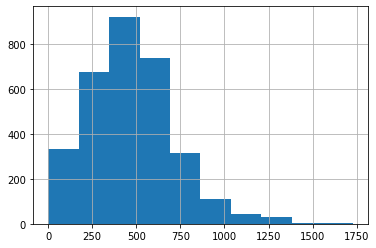

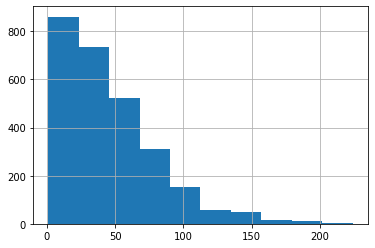

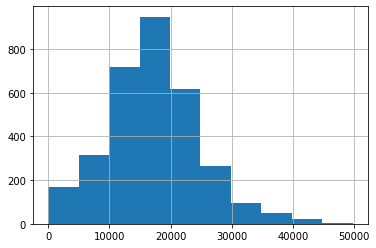

График выручки с тарифа smart c каждого пользователя


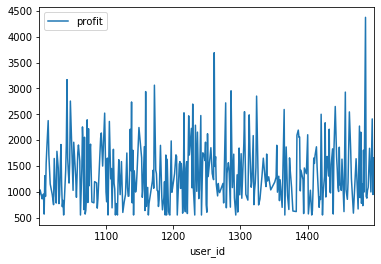

График выручки с тарифа ultra c каждого пользователя


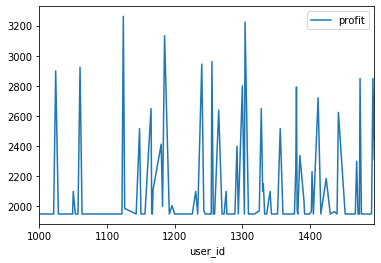

In [14]:
users_final['sum_of_min'].hist(bins = 10)
plt.show()
users_final['sum_messages'].hist(bins = 10)
plt.show()
users_final['sum_internet'].hist(bins = 10)
plt.show()

print('График выручки с тарифа smart c каждого пользователя')
analyze_smart = users_final.query('tariff_name == "smart"').groupby('user_id').agg({'profit' : 'mean'})
analyze_smart.plot(y = 'profit')
plt.show()

print('График выручки с тарифа ultra c каждого пользователя')
analyze_ultra = users_final.query('tariff_name == "ultra"').groupby('user_id').agg({'profit' : 'mean'})
analyze_ultra.plot(y = 'profit')
plt.show()

Сравнение среднего количества минут разговоров по месяцам для двух тарифов


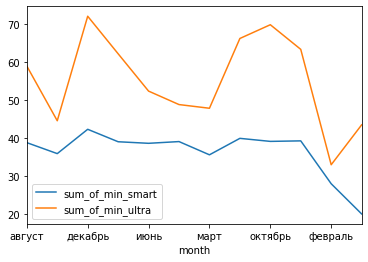

Сравнение среднего количества отправленных смс по месяцам для двух тарифов


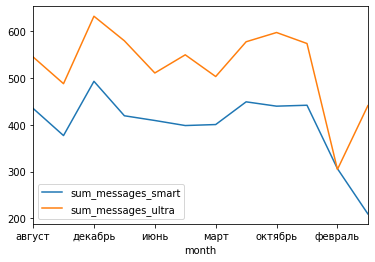

Сравнение среднего количества потраченных мегабайт по месяцам для двух тарифов


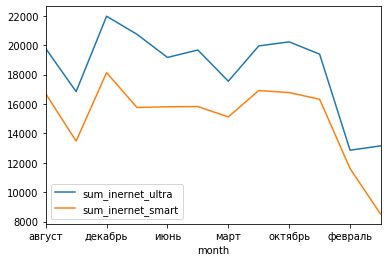

Сравнение среднего количества прибыли по месяцам для двух тарифов


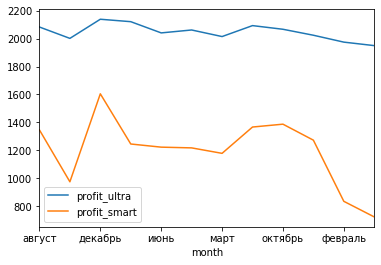

In [9]:
print('Сравнение среднего количества минут разговоров по месяцам для двух тарифов')
users_final['sum_of_min_ultra'] = users_final[users_final['tariff_name']=='ultra']['sum_messages']
users_final['sum_of_min_smart'] = users_final[users_final['tariff_name']=='smart']['sum_messages']
users_call_min = users_final.groupby(['month']).agg({'sum_of_min_smart' : 'mean','sum_of_min_ultra' : 'mean'}).plot(y = ['sum_of_min_smart','sum_of_min_ultra'])
plt.show()

print('Сравнение среднего количества отправленных смс по месяцам для двух тарифов')
users_final['sum_messages_ultra'] = users_final[users_final['tariff_name']=='ultra']['sum_of_min']
users_final['sum_messages_smart'] = users_final[users_final['tariff_name']=='smart']['sum_of_min']
users_messages = users_final.groupby(['month']).agg({'sum_messages_smart' : 'mean','sum_messages_ultra' : 'mean'}).plot(y = ['sum_messages_smart','sum_messages_ultra'])
plt.show()

print('Сравнение среднего количества потраченных мегабайт по месяцам для двух тарифов')
users_final['sum_inernet_ultra'] = users_final[users_final['tariff_name']=='ultra']['sum_internet']
users_final['sum_inernet_smart'] = users_final[users_final['tariff_name']=='smart']['sum_internet']
users_call_min = users_final.groupby(['month']).agg({'sum_inernet_ultra' :'mean','sum_inernet_smart':'mean'}).plot(y = ['sum_inernet_ultra','sum_inernet_smart'])
plt.show()

print('Сравнение среднего количества прибыли по месяцам для двух тарифов')
users_final['profit_ultra'] = users_final[users_final['tariff_name']=='ultra']['profit']
users_final['profit_smart'] = users_final[users_final['tariff_name']=='smart']['profit']
users_call_min = users_final.groupby(['month']).agg({'profit_ultra' : 'mean','profit_smart' : 'mean'}).plot(y = ['profit_ultra','profit_smart'])
plt.show()

### Вывод

- Стандартное отклонение и дисперсия тарифа `ultra` превышают значения тарифа `smart` - это логично, ведь в первом тарифе выделено значительно больше звонков, смс, интеренет трафика
- Исходя из диаграмм размаха пользователи тарифа `ultra` тратят больше ресурсов, но при этом нельзя с уверенностью сказать, что средняя выручка с этих пользователей больше, чем с пользователей тарифа `smart`. Во втором случае мы наблюдаем скошенную влево диаграмму и её среднее будет смещено ближе к средней выручке `ultra`. 
Хотя исходя из таблицы средних значений выручка `ultra` превышает `smart` почти в 1.6 раза, данные вычесления были сделаны без учёта выбросов и относятся всего лишь к выборке. 
- Построены графики сравнения потраченных клиентами ресурсов между двумя тарифами

 ### Шаг 4. Проверка гипотез. 

In [10]:
print('Нулевая гипотеза: выручки тарифов равны между собой')
alpha = 0.05
results_tariff = st.ttest_ind(users_final[users_final['tariff_name'] == 'ultra']['profit'], users_final[users_final['tariff_name'] == 'smart']['profit'],equal_var = False)
print('p-значение:', results_tariff.pvalue)

if (results_tariff.pvalue < alpha):
    print()
    print("Отвергаем нулевую гипотезу")
    print("Значит альтернативная гипотеза: выручки тарифов различаются - верна")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()
print('Нулевая гипотеза: выручки c клиентов из Москвы и других городов равны между собой')
users_final = users_final.merge(users,on = 'user_id', how = 'left')
results_city = st.ttest_ind(users_final[users_final['city'] == 'Москва']['profit'], users_final[users_final['city'] != 'Москва']['profit'],equal_var = False)
print('p-значение:', results_city.pvalue)

if (results_city.pvalue < alpha):
    # ваш код: сравните получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Нулевая гипотеза: выручки тарифов равны между собой
p-значение: 2.2071398635388928e-234

Отвергаем нулевую гипотезу
Значит альтернативная гипотеза: выручки тарифов различаются - верна

Нулевая гипотеза: выручки c клиентов из Москвы и других городов равны между собой
p-значение: 0.5612228736965572
Не получилось отвергнуть нулевую гипотезу


### Вывод

- Нулевая гипотеза сравнения выручки тарифов формировалась исходя из критерия, что если средние выручки с большой долей вероятности не будут равны, мы можем подтвердить альтернативную гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

- Нулевая гипотеза сравнения выручки Москвы и других городов формировалась исходя из критерия, что если средние выручки с большой долей вероятности не будут равны, мы можем подтвердить альтернативную гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### Общий вывод

По итогу работы я не смог сделать однозначный вывод, какой из тарифов **в целом** более выгодный, для этого требуется формирование большего числа гипотез для генеральной совокупности 
- Для данной выборки можно с уверенностью сказать, что от тарифа `ultra` компания имеет большую выручку, но при этом клиенты данного тарифа тратят больше ресурсов(звонки, сообщения, интернет) исходя из графиков сравнения
- Для генеральной совокупности можно сделать вывод, что с большой вероятностью выручка с двух предложеных тарифов отличается и не зависит от того из Москвы клиент или из другого города.